In [1]:
import numpy as np
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers

## Create Simulated Data

In [2]:
def create_data(n=100):
    """
        f(x1, x2) = 5 * x_1**2 + 4 * x_2**2 - 3 * x_1 * x_2
    """
    ret = np.zeros(shape=(n, 3)).astype("float32")
    x = np.random.rand(n, 2)
    y = (5 * x[:, 0]**2 + 4 * x[:, 1]**2 - 3 * x[:, 0] * x[:, 1]).reshape(-1, 1)
    ret[:, [0, 1]] = x
    ret[:, [2]] = y
    
    return ret

## Test Out Function

In [3]:
d = create_data(4)

In [4]:
d

array([[0.9540869 , 0.66388   , 4.414158  ],
       [0.20510316, 0.39493704, 0.5912291 ],
       [0.82627183, 0.6225188 , 3.4206347 ],
       [0.14957464, 0.27874026, 0.29756996]], dtype=float32)

In [5]:
val = round(5 * d[0, 0]**2 + 4 * d[0, 1]**2 - 3 * d[0, 0] * d[0, 1], 4)
exp_val = round(d[0, 2], 4)

val, exp_val

(4.4142, 4.4142)

## Create Network

The network that we will create will have two dense layers with ReLU activations. The goal is to see how many of these neurons become "dead".

### Train and Test Data

In [6]:
NUM_SAMPLES = 1000
TRAIN_FRAC = 0.60
VAL_FRAC = 0.20

data = create_data(n=1000)

train_idx = int(TRAIN_FRAC * NUM_SAMPLES)
val_idx = train_idx + int(VAL_FRAC * NUM_SAMPLES)

train_data = data[: train_idx]
val_data = data[train_idx: val_idx]
test_data = data[val_idx: ]

### Normalizer 

In [7]:
def normalize(data: np.array, mean: np.array=None, sd: np.array=None):
    if (mean is not None) and (sd is not None):
        assert data.shape[1] == len(mean) == len(sd)
    
    if mean is None:
        mean = data.mean(axis=0)
    if sd is None:
        sd = data.std(axis=0)
    
    normed = (data - mean) / sd
    
    return mean, sd, normed

In [8]:
mean, sd, norm_train_data = normalize(train_data)
_, _, norm_val_data = normalize(val_data, mean=mean, sd=sd)
_, _, norm_test_data = normalize(test_data, mean=mean, sd=sd)

### Model Layers

In [9]:
NUM_UNITS = 2

inputs = keras.Input(shape=2)

dense_1 = layers.Dense(units=NUM_UNITS, activation='relu')(inputs)
#leaky_1 = tf.keras.layers.LeakyReLU(dense_1)

dense_2 = layers.Dense(units=NUM_UNITS, activation='relu')(dense_1)
#leaky_2 = tf.keras.layers.LeakyReLU(dense_2) 

output = layers.Dense(units=1, activation=None)(dense_2)

In [10]:
model = keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback


checkpoint_filepath = './checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

weights_dict = {}

weight_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: weights_dict.update({epoch: model.get_weights()})
)

In [13]:
BATCH_SIZE = 32
EPOCHS = 10

train_dataset = tf.data.Dataset.from_tensor_slices((test_data[:, [0, 1]], 
                                                    test_data[:, [2]])).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data[:, [0, 1]], 
                                                  val_data[:, [2]])).batch(BATCH_SIZE)

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=val_dataset, 
                    callbacks=[weight_callback])

Epoch 1/10
7/7 [==============================] - 1s 48ms/step - loss: 7.4873 - val_loss: 6.0753
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 7.3468 - val_loss: 5.9797
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 7.2402 - val_loss: 5.8889
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 7.1371 - val_loss: 5.8020
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 7.0385 - val_loss: 5.7137
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 6.9401 - val_loss: 5.6246
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 6.8420 - val_loss: 5.5349
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 6.7446 - val_loss: 5.4452
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 6.6443 - val_loss: 5.3505
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 6.5386 - val_loss: 5.2526


In [14]:
pred = model.predict(test_data[:, [0, 1]])

In [15]:
np.mean((pred - test_data[:, [2]])**2)

6.182959

## Evolution of Weights by Epoch

In [16]:
weights_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
weights_dict[0]

[array([[ 1.2377868 ,  1.05014   ],
        [ 0.8190128 , -0.92086786]], dtype=float32),
 array([ 0.01586576, -0.01362065], dtype=float32),
 array([[ 0.0562371 ,  0.03250096],
        [-0.7684277 ,  1.0155653 ]], dtype=float32),
 array([ 0.01484725, -0.01251459], dtype=float32),
 array([[ 0.7917157 ],
        [-0.07399683]], dtype=float32),
 array([0.01282802], dtype=float32)]

In [18]:
# these are the weights from the input x1 to the the 10 neurons in the first layer
weights_dict[0][0][0]

array([1.2377868, 1.05014  ], dtype=float32)

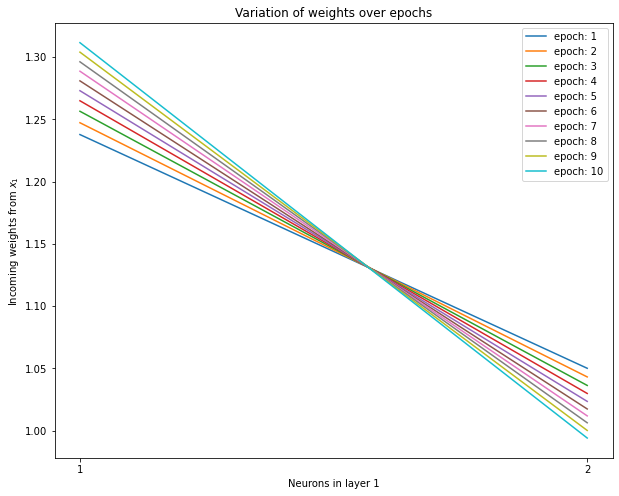

In [19]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
x_vals = range(1, NUM_UNITS + 1)

for epoch in range(0, EPOCHS):
    weights = weights_dict[epoch][0][0]
    ax.plot(x_vals, weights, label=f'epoch: {epoch + 1}')

ax.set_title('Variation of weights over epochs')
ax.set_xticks(range(1, NUM_UNITS + 1))
ax.set_xlabel('Neurons in layer 1')
ax.set_ylabel(r'Incoming weights from $x_1$')
plt.legend();

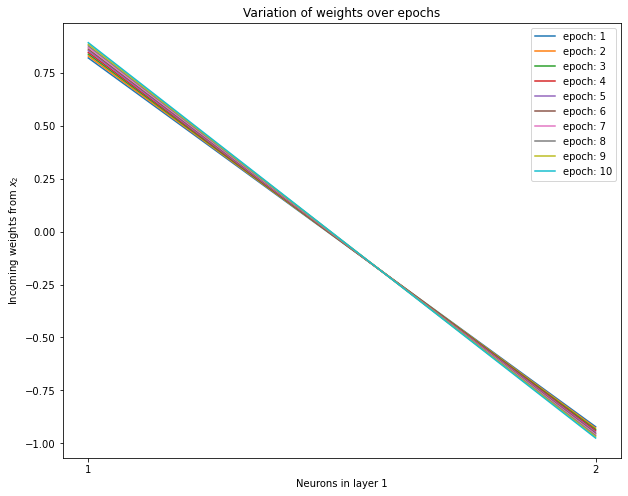

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
x_vals = range(1, NUM_UNITS + 1)

for epoch in range(0, EPOCHS):
    weights = weights_dict[epoch][0][1]
    ax.plot(x_vals, weights, label=f'epoch: {epoch + 1}')
    
ax.set_title('Variation of weights over epochs')
ax.set_xticks(range(1, NUM_UNITS + 1))
ax.set_xlabel('Neurons in layer 1')
ax.set_ylabel(r'Incoming weights from $x_2$')
plt.legend();

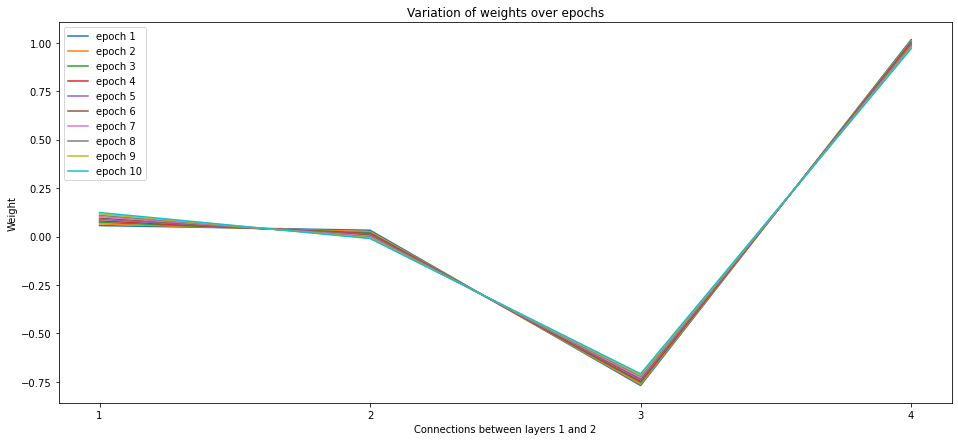

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
x_vals = range(1, NUM_UNITS**2 + 1)

for epoch in range(0, EPOCHS):
    weights = weights_dict[epoch][2].flatten()
    ax.plot(x_vals, weights, label=f'epoch {epoch + 1}')
    

ax.set_title('Variation of weights over epochs')

if NUM_UNITS < 6:
    ax.set_xticks(range(1, NUM_UNITS**2 + 1))

ax.set_xlabel('Connections between layers 1 and 2')
ax.set_ylabel('Weight')
plt.legend();